In [1]:
import pickle
import numpy as np
import warnings
from scipy.stats import gaussian_kde
import seaborn as sns
from scipy.interpolate import InterpolatedUnivariateSpline, UnivariateSpline
from settings import *
from tools import get_mids
from matplotlib.colors import LogNorm
from scipy.special import erf
from scipy.stats import norm
from scipy.interpolate import RegularGridInterpolator

matplotlib = sns.mpl
plt = matplotlib.pyplot
plt.style.use("../style.mplstyle")
colorlist = plt.rcParams["axes.prop_cycle"].by_key()["color"]
warnings.filterwarnings("ignore")


Could not import healpy.
functions plot_area, add_catalog, and add_extended_plane will not work.


In [2]:
# Calculate energy smearing
# this takes a couple of seconds
public_data_hist = np.genfromtxt("../resources/IC86_II_smearing.csv", skip_header=1)

log_sm_emids = (public_data_hist[:, 0] + public_data_hist[:, 1]) / 2.0
log_sm_ereco_mids = (public_data_hist[:, 4] + public_data_hist[:, 5]) / 2.0
fractional_event_counts = public_data_hist[:, 10]

e_ereco_kdes = gaussian_kde(
    (log_sm_emids, log_sm_ereco_mids), weights=fractional_event_counts
)


In [3]:
def double_erf(x, shift_l, shift_r, sigma):
    # normalized such that ig goes from 0 to 1 and back to 0
    return (erf((x - shift_l) / sigma) + 1) * (-erf((x - shift_r) / sigma) + 1) / 4


# Binning

In [4]:
bin_size = 0.1
logE_bins = np.arange(1.5, 9.2, step=bin_size)
logE_mids = get_mids(logE_bins)
logE_reco_bins = np.arange(0.5, 9.3, step=bin_size)
logE_reco_mids = get_mids(logE_reco_bins)
ee, rr = np.meshgrid(logE_mids, logE_reco_mids)


# Original smearing matrix

In [5]:
normed_kvals = e_ereco_kdes([ee.flatten(), rr.flatten()]).reshape(
    len(logE_reco_mids), len(logE_mids)
)
normed_kvals /= np.sum(normed_kvals, axis=0)


In [6]:
rgi = RegularGridInterpolator((logE_reco_mids, logE_mids), normed_kvals)


In [7]:
with open("../resources/energy_smearing_rgi.pckl", "wb") as f:
    pickle.dump(rgi, f)

with open("../resources/energy_smearing_kde.pckl", "wb") as f:
    pickle.dump((e_ereco_kdes, normed_kvals, logE_reco_bins), f)

with open("../resources/energy_smearing_2D.pckl", "wb") as f:
    pickle.dump((normed_kvals, logE_bins, logE_reco_bins), f)


Text(0.5, 0, 'log(E true (neutrino) / GeV)')

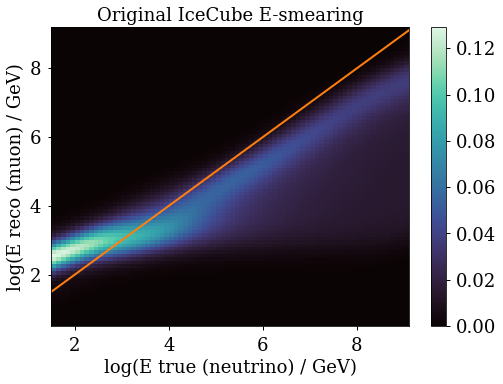

In [8]:
plt.grid(False)
plt.pcolormesh(logE_bins, logE_reco_bins, normed_kvals)  # , norm=LogNorm(vmin=1E-9))
plt.colorbar()
plt.plot([1, 9.5], [1, 9.5], color="tab:orange")
plt.ylim(np.min(logE_reco_bins), np.max(logE_reco_bins))
plt.xlim(np.min(logE_bins), np.max(logE_bins))
plt.title("Original IceCube E-smearing")
plt.ylabel("log(E reco (muon) / GeV)")
plt.xlabel("log(E true (neutrino) / GeV)")


# Parameterize the smearing matrix

In [9]:
logE_reco_mode = []
kv_mode = []
kv_sigma = []
kv_thresh = []
# find the mode of E-reco distribution in each slice of E-true
for ii, et in enumerate(logE_mids):
    max_ind = np.argmax(normed_kvals[:, ii])
    logE_reco_mode.append(logE_reco_mids[max_ind])
    kv_mode.append(normed_kvals[max_ind, ii])

    sigma_val = kv_mode[-1] / np.sqrt(np.e)
    # above mode
    mask = logE_reco_mids > logE_reco_mode[ii]
    # kval below sigma
    mask &= normed_kvals[:, ii] <= sigma_val
    tmp = np.interp(
        sigma_val,
        [normed_kvals[:, ii][~mask][-1], normed_kvals[:, ii][mask][0]],
        [logE_reco_mids[~mask][-1], logE_reco_mids[mask][0]],
    )

    kv_sigma.append(tmp - logE_reco_mode[-1])
    kv_thresh.append(logE_reco_mids[normed_kvals[:, ii] > 0.005][0])


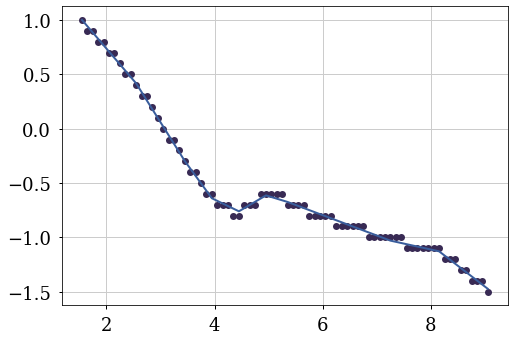

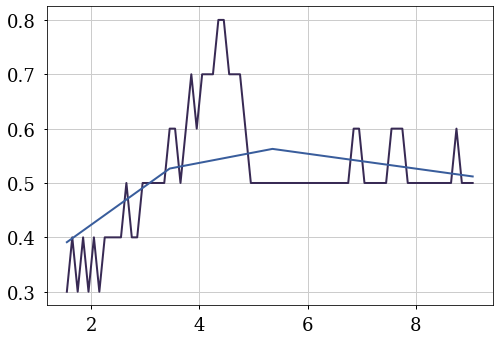

In [10]:
# Interpolate the E-reco peak position and width
# e_spline = InterpolatedUnivariateSpline(logE_mids, logE_reco_mode)
e_spline = UnivariateSpline(logE_mids, logE_reco_mode, s=0.07, k=1)
sig_spline = UnivariateSpline(logE_mids, kv_sigma, s=0.5, k=1)

plt.figure()
plt.plot(logE_mids, logE_reco_mode - logE_mids, lw=0, marker="o")
plt.plot(logE_mids, e_spline(logE_mids) - logE_mids)

plt.figure()
plt.plot(logE_mids, kv_sigma)
plt.plot(logE_mids, sig_spline(logE_mids))


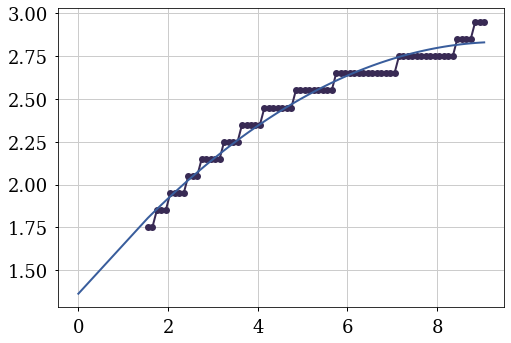

In [11]:
# energy treshold
pfunc = np.poly1d(np.polyfit(logE_mids, kv_thresh, 2))
x = np.concatenate([[0], logE_mids])
plt.plot(logE_mids, kv_thresh, marker="o")
plt.plot(x, pfunc(x))


In [12]:
sns.set_palette("mako", n_colors=10)


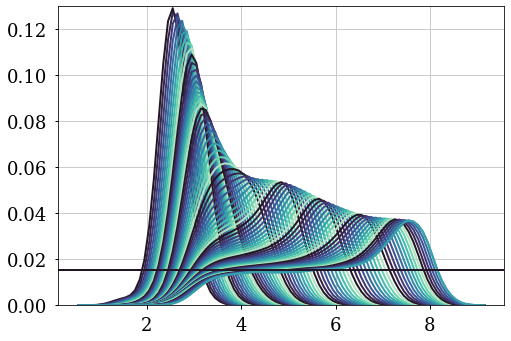

In [13]:
## as reference: this is the original slicing
for i in np.concatenate([np.arange(0, len(logE_reco_mode), step=1), [-1]]):
    p = plt.plot(logE_reco_mids, normed_kvals[:, i])
plt.ylim(0, 0.13)
plt.axhline(normed_kvals[50][-1])


# Artificial smearing matrix

## Best reproduction

Text(0.5, 0, 'log(E true (neutrino) / GeV)')

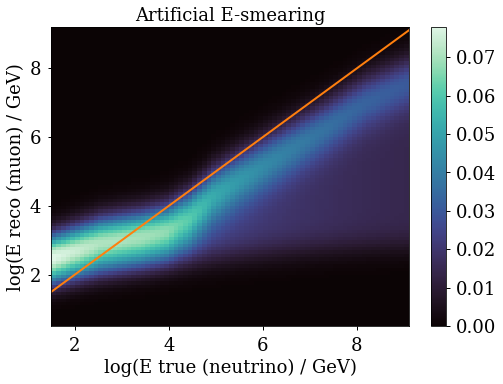

In [14]:
dx = logE_reco_bins[1] - logE_reco_bins[0]
artificial_2D = []
for e_t in logE_mids:
    mu_N = e_spline(e_t)
    # "energy threshold"
    shift_l = pfunc(e_t)
    # energy resolution of the muon in log(E)
    # and slope shape
    sigma_S = sigma_N = sig_spline(mu_N)
    shift_r = mu_N - sigma_S

    norbert = norm.pdf(logE_reco_mids, loc=mu_N, scale=sigma_N)
    # normalize such that the plateau is half as high as the gauss
    siggi_norm = norm.pdf(mu_N, loc=mu_N, scale=sigma_N) / 2
    siggi = double_erf(logE_reco_mids, shift_l, shift_r, sigma_S)
    siggi *= siggi_norm

    combined = siggi + norbert
    combined /= np.sum(combined * dx)  # normalize
    artificial_2D.append(combined)
artificial_2D = np.array(artificial_2D).T
artificial_2D /= np.sum(artificial_2D, axis=0)
with open("../resources/artificial_energy_smearing_kde.pckl", "wb") as f:
    pickle.dump((artificial_2D, logE_reco_bins), f)

rgi = RegularGridInterpolator((logE_reco_mids, logE_mids), artificial_2D)
with open("../resources/artificial_energy_smearing_rgi.pckl", "wb") as f:
    pickle.dump(rgi, f)


plt.figure()
aee, arr = np.meshgrid(logE_bins, logE_reco_bins)
plt.pcolormesh(aee, arr, artificial_2D)
plt.ylim(np.min(arr), np.max(arr))
plt.xlim(np.min(aee), np.max(aee))
plt.plot([1, 10], [1, 10], color="tab:orange")
plt.colorbar()
plt.title("Artificial E-smearing")
plt.ylabel("log(E reco (muon) / GeV)")
plt.xlabel("log(E true (neutrino) / GeV)")


## 1:1 reco reproduction

Text(0.5, 0, 'log(E true (neutrino) / GeV)')

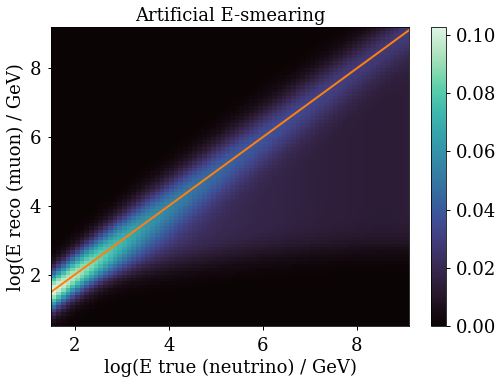

In [15]:
artificial_2D = []

for e_t in logE_mids:
    mu_N = e_t
    # slightly shift the "energy threshold"
    shift_l = pfunc(e_t)
    sigma_S = sigma_N = sig_spline(mu_N)
    shift_r = mu_N - sigma_S

    norbert = norm.pdf(logE_reco_mids, loc=mu_N, scale=sigma_N)
    # normalize such that the plateau is half as high as the gauss
    siggi_norm = norm.pdf(0, loc=0, scale=sigma_N) / 2
    siggi = double_erf(logE_reco_mids, shift_l, shift_r, sigma_S)
    siggi *= siggi_norm

    combined = siggi + norbert
    combined /= np.sum(combined * dx)  # normalize
    # plt.figure(1)
    # plt.plot(logE_reco_bins, combined)
    artificial_2D.append(combined)
artificial_2D = np.array(artificial_2D).T
artificial_2D /= np.sum(artificial_2D, axis=0)
with open("../resources/idealized_artificial_energy_smearing_kde.pckl", "wb") as f:
    pickle.dump((artificial_2D, logE_reco_bins), f)

rgi = RegularGridInterpolator((logE_reco_mids, logE_mids), artificial_2D)
with open("../resources/idealized_artificial_energy_smearing_rgi.pckl", "wb") as f:
    pickle.dump(rgi, f)


plt.figure()
aee, arr = np.meshgrid(logE_bins, logE_reco_bins)
plt.pcolormesh(aee, arr, artificial_2D)
plt.ylim(np.min(arr), np.max(arr))
plt.xlim(np.min(aee), np.max(aee))
plt.plot([1, 10], [1, 10], color="tab:orange")
plt.colorbar()
plt.title("Artificial E-smearing")
plt.ylabel("log(E reco (muon) / GeV)")
plt.xlabel("log(E true (neutrino) / GeV)")


## Improved artificial energy smearing

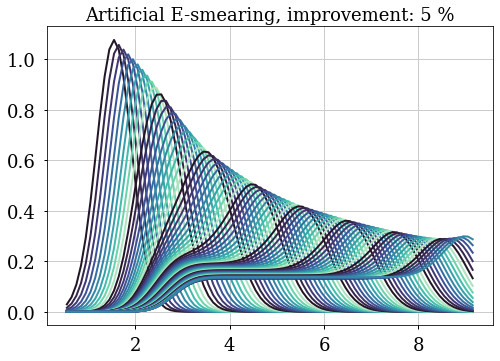

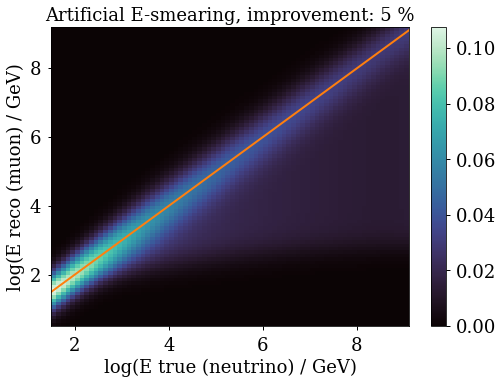

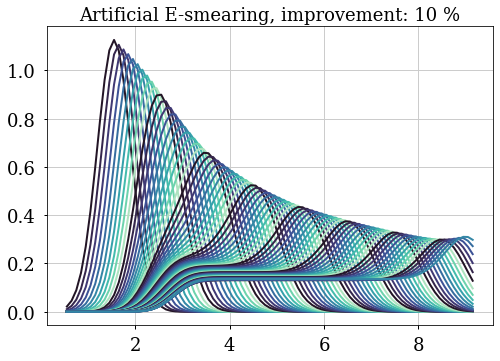

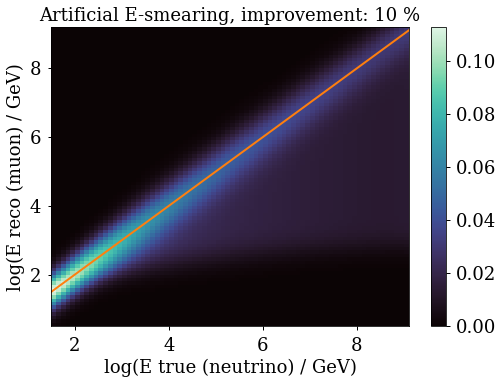

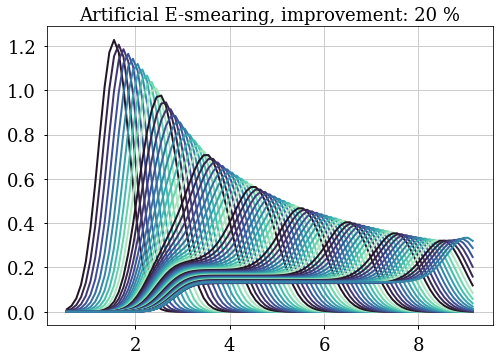

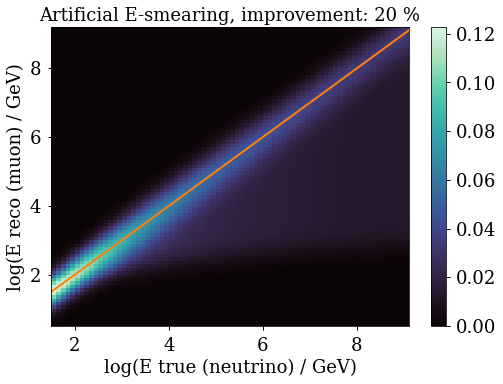

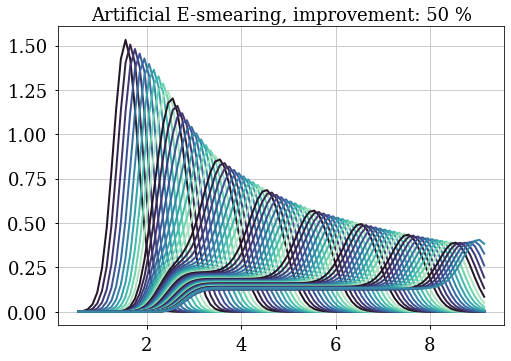

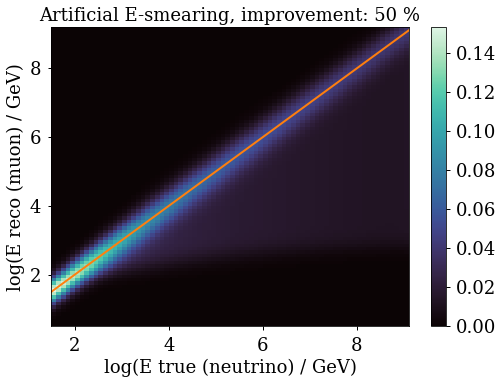

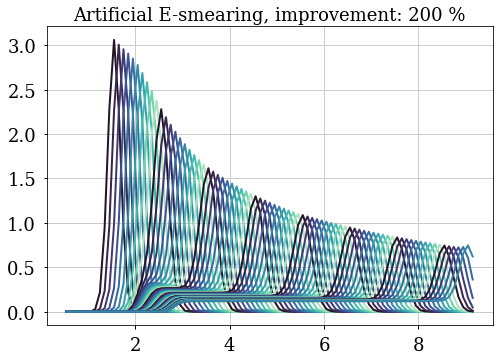

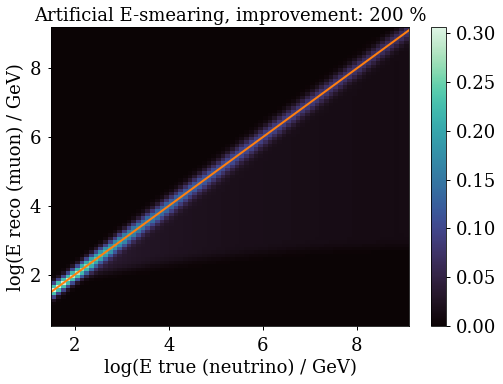

In [16]:
for ii, impro_factor in enumerate([0.05, 0.1, 0.2, 0.5, 2]):

    artificial_2D = []
    plt.figure(ii)
    plt.title(f"Artificial E-smearing, improvement: {impro_factor*100:1.0f} %")
    for e_t in logE_mids:
        mu_N = e_t
        # slightly shift the "energy threshold"
        shift_l = pfunc(e_t)
        # improved energy resolution in gauss peak
        sigma_S = sigma_N = sig_spline(mu_N) / (1 + impro_factor)
        shift_r = mu_N - sigma_S

        norbert = norm.pdf(logE_reco_mids, loc=mu_N, scale=sigma_N)
        # normalize such that the plateau is half as high as the gauss
        siggi_norm = norm.pdf(0, loc=0, scale=sig_spline(mu_N)) / 2
        siggi = double_erf(logE_reco_mids, shift_l, shift_r, sigma_S)
        siggi *= siggi_norm

        combined = siggi + norbert
        combined /= np.sum(combined * dx)  # normalize
        plt.plot(logE_reco_mids, combined)
        artificial_2D.append(combined)
    artificial_2D = np.array(artificial_2D).T
    artificial_2D /= np.sum(artificial_2D, axis=0)
    with open(
        f"../resources/improved_{impro_factor}_artificial_energy_smearing_kde.pckl",
        "wb",
    ) as f:
        pickle.dump((artificial_2D, logE_reco_bins), f)

    rgi = RegularGridInterpolator((logE_reco_mids, logE_mids), artificial_2D)
    with open(
        f"../resources/improved_{impro_factor}_artificial_energy_smearing_rgi.pckl",
        "wb",
    ) as f:
        pickle.dump(rgi, f)

    plt.figure(ii + 20)
    plt.pcolormesh(logE_bins, logE_reco_bins, artificial_2D)
    plt.ylim(np.min(logE_reco_bins), np.max(logE_reco_bins))
    plt.xlim(np.min(logE_bins), np.max(logE_bins))
    plt.plot([1, 10], [1, 10], color="tab:orange")
    plt.colorbar()
    plt.title(f"Artificial E-smearing, improvement: {impro_factor*100:1.0f} %")
    plt.ylabel("log(E reco (muon) / GeV)")
    plt.xlabel("log(E true (neutrino) / GeV)")


# UHE energy smearing

## binning

In [17]:
bin_size = 0.1
logE_min = 7.
logE_bins_HE = np.arange(7.5, 13, step=bin_size)
logE_mids_HE = get_mids(logE_bins_HE)
logE_reco_bins_HE = np.arange(logE_min, 13.5, step=bin_size)
logE_reco_mids_HE = get_mids(logE_reco_bins_HE)
hee, hrr = np.meshgrid(logE_mids_HE, logE_reco_mids_HE)

## calculation

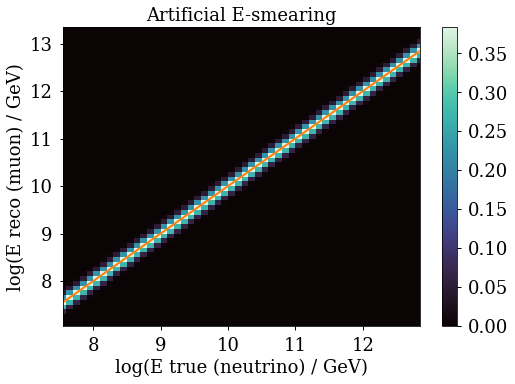

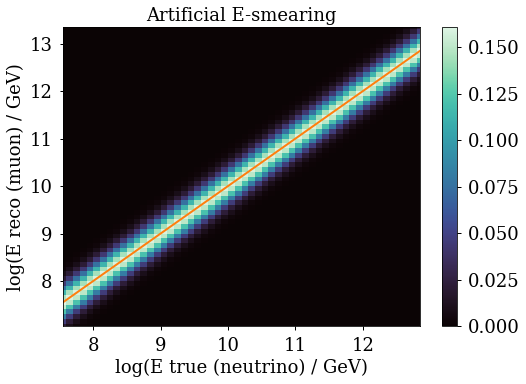

In [18]:
for res in [0.1, 0.25]:
    dx = logE_reco_bins_HE[1] - logE_reco_bins_HE[0]
    HE_2D = []
    sigma_S = sigma_N = res  # energy resolution in log10(E)

    for e_t in logE_mids_HE:
        mu_N = e_t
        # energy resolution of the muon in log(E)
        # and slope shape
        shift_r = mu_N - sigma_S
        shift_l = mu_N + np.log10(1 - 0.2) # modeling mean inelasticity y ~ 20% at E=10⁹ GeV

        norbert = norm.pdf(logE_reco_mids_HE, loc=mu_N, scale=sigma_N)
        # normalize such that the plateau is half as high as the gauss
        siggi_norm = norm.pdf(mu_N, loc=mu_N, scale=sigma_N) / 2
        siggi = double_erf(logE_reco_mids_HE, shift_l, shift_r, sigma_S)
        siggi *= siggi_norm

        combined = siggi + norbert
        combined /= np.sum(combined * dx)  # normalize
        HE_2D.append(combined)
    HE_2D = np.array(HE_2D).T
    HE_2D /= np.sum(HE_2D, axis=0)

    plt.figure()
    plt.pcolormesh(hee, hrr, HE_2D)
    plt.ylim(np.min(hrr), np.max(hrr))
    plt.xlim(np.min(hee), np.max(hee))
    plt.plot([6, 13], [6, 13], color="tab:orange")
    plt.colorbar()
    plt.title("Artificial E-smearing")
    plt.ylabel("log(E reco (muon) / GeV)")
    plt.xlabel("log(E true (neutrino) / GeV)")

    ## save
    with open(f"../resources/HE_energy_smearing_kde_{int(res*100)}-res.pckl", "wb") as f:
        pickle.dump((HE_2D, logE_reco_bins_HE), f)

    rgi = RegularGridInterpolator((logE_reco_mids_HE, logE_mids_HE), HE_2D)
    with open(f"../resources/HE_energy_smearing_rgi_{int(res*100)}-res.pckl", "wb") as f:
        pickle.dump(rgi, f)

    with open(f"../resources/HE_energy_smearing_2D_{int(res*100)}-res.pckl", "wb") as f:
        pickle.dump((HE_2D, logE_bins_HE, logE_reco_bins_HE), f)

# Check & Plot

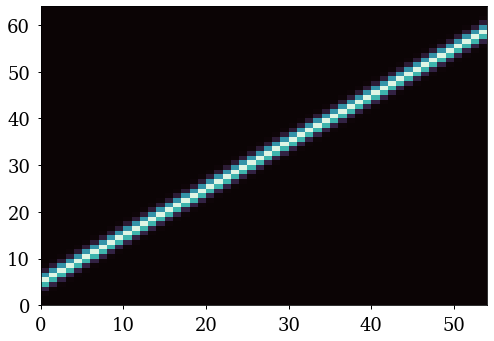

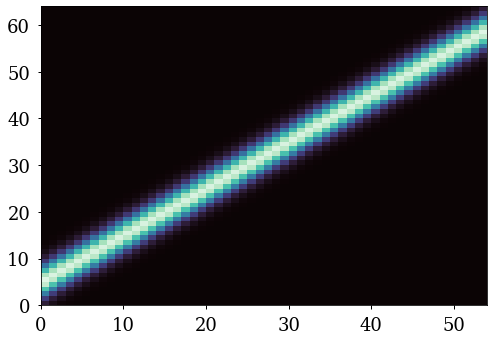

In [19]:
# energy smearing matrix
with open("../resources/HE_energy_smearing_2D_10-res.pckl", "rb") as f:
    HE_2D, logE_bins_HE, logE_reco_bins_HE = pickle.load(f)

plt.figure()
plt.pcolormesh(HE_2D)

# energy smearing matrix
with open("../resources/HE_energy_smearing_2D_25-res.pckl", "rb") as f:
    HE_2D, logE_bins_HE, logE_reco_bins_HE = pickle.load(f)

plt.figure()
plt.pcolormesh(HE_2D)


In [20]:
# energy smearing matrix
with open("../resources/energy_smearing_rgi.pckl", "rb") as f:
    rgi = pickle.load(f)
# new binning
logE_reco_bins = np.arange(1.9, 9.05, step=0.05)
logE_reco_mids = get_mids(logE_reco_bins)
lge_grid, lre_grid = np.meshgrid(logE_mids, logE_reco_mids)
# baseline evaluation
normed_kvals = rgi((lre_grid, lge_grid))

# normalize per bin in true energy
normed_kvals = normed_kvals / np.sum(normed_kvals, axis=0)

# artificial, improved smearing matrix
with open("../resources/improved_0.5_artificial_energy_smearing_rgi.pckl", "rb") as f:
    rgi = pickle.load(f)
artificial_normed_kvals = rgi((lre_grid, lge_grid))
# normalize per bin in true energy
artificial_normed_kvals = artificial_normed_kvals / np.sum(
    artificial_normed_kvals, axis=0
)


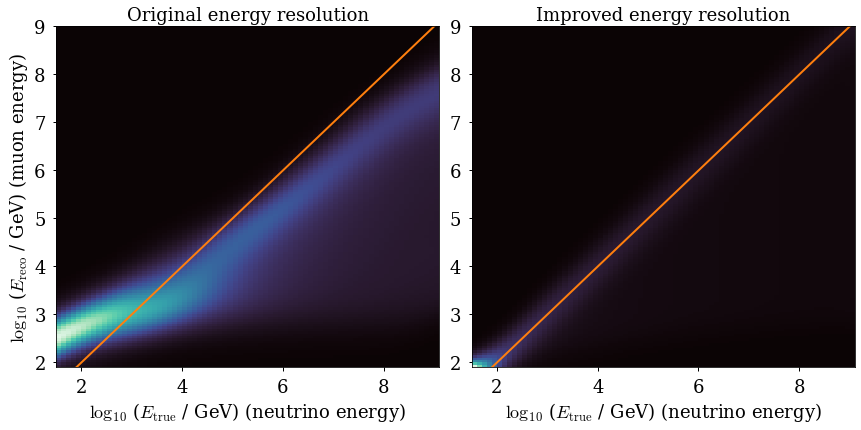

In [21]:
# logE_mids are the same as for effective area binning
f, axes = plt.subplots(ncols=2, figsize=(12, 6))

axes[0].grid(False)
axes[0].pcolormesh(logE_bins, logE_reco_bins, normed_kvals)
# f.colorbar()
axes[0].plot([1, 10], [1, 10], color="tab:orange")
axes[0].set_ylim(np.min(logE_reco_bins), np.max(logE_reco_bins))
axes[0].set_xlim(np.min(logE_bins), np.max(logE_bins))
axes[0].set_title("Original energy resolution")
axes[0].set_ylabel(r"$\log_{10}$ ($E_{\rm reco}$ / GeV) (muon energy)")
axes[0].set_xlabel(r"$\log_{10}$ ($E_{\rm true}$ / GeV) (neutrino energy)")

## Artificial
axes[1].grid(False)
axes[1].pcolormesh(logE_bins, logE_reco_bins, artificial_normed_kvals)
# f.colorbar()
axes[1].plot([1, 10], [1, 10], color="tab:orange")
axes[1].set_ylim(np.min(logE_reco_bins), np.max(logE_reco_bins))
axes[1].set_xlim(np.min(logE_bins), np.max(logE_bins))
axes[1].set_title("Improved energy resolution")
# axes[1].set_ylabel(r"$\log_{10}$ ($E_{\rm reco}$ / GeV) (muon energy)")
axes[1].set_xlabel(r"$\log_{10}$ ($E_{\rm true}$ / GeV) (neutrino energy)")
f.tight_layout()
f.savefig("../plots/energy_resolution_comparison.pdf", bbox_inches="tight")
